## Machine Learning - Project III

This project analyzes a comprehensive dataset of 515,000 hotel reviews from across Europe to extract meaningful insights about user behavior and hotel performance. Using a combination of supervised and unsupervised learning techniques, we explore patterns in review sentiment,predict reviewer scores, and identify geographical clusters of similarly-rated hotels.

The analysis includes:
1. Exploratory data analysis of review patterns across different nationalities and hotel types
2. Classification of reviews as above or below average using Random Forest
3. Feature importance analysis to understand key factors influencing hotel ratings
4. Hyperparameter tuning to optimize model performance
5. Geographical clustering to identify patterns in hotel distribution and quality

This project demonstrates practical applications of machine learning in the hospitality industry,
providing actionable insights for both travelers and hotel management.


## Data Exploration

In [56]:
# Load Reviews Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Suppress all warnings
warnings.filterwarnings("ignore")

reviews_path = "/Users/sezinmumcu/Downloads/Hotel_Reviews.csv"
reviews_data = pd.read_csv(reviews_path)

In [33]:
# Display basic info about the dataset
print("Dataset Head:\n", reviews_data.head())

Dataset Head:
                                        Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                      

In [6]:
print("Dataset Info:\n")
print(reviews_data.info())

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-

In [7]:
# Fill missing text values
reviews_data.fillna({"Negative_Review": "No Negative", "Positive_Review": "No Positive"}, inplace=True)

# Convert Review_Date to datetime
reviews_data['Review_Date'] = pd.to_datetime(reviews_data['Review_Date'])

# Fill missing numeric columns with the mean
numeric_cols = reviews_data.select_dtypes(include='number')
reviews_data[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

# Replace invalid values if necessary (example: Negative word counts being < 0)
reviews_data['Review_Total_Negative_Word_Counts'] = np.maximum(0, reviews_data['Review_Total_Negative_Word_Counts'])
reviews_data['Review_Total_Positive_Word_Counts'] = np.maximum(0, reviews_data['Review_Total_Positive_Word_Counts'])

# Verify cleaning
print("Missing Values After Cleaning:\n", reviews_data.isnull().sum())

Missing Values After Cleaning:
 Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64


In [11]:
# 1. Summary Statistics
print("Basic Statistics of Numerical Features:")
print(reviews_data.describe())

Basic Statistics of Numerical Features:
       Additional_Number_of_Scoring  Average_Score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.

In [12]:
# 2. Missing Values Overview
missing_values = reviews_data.isnull().sum()
missing_percentage = (missing_values / len(reviews_data)) * 100
print("\nMissing Values (%):")
print(missing_percentage[missing_percentage > 0])


Missing Values (%):
lat    0.633655
lng    0.633655
dtype: float64


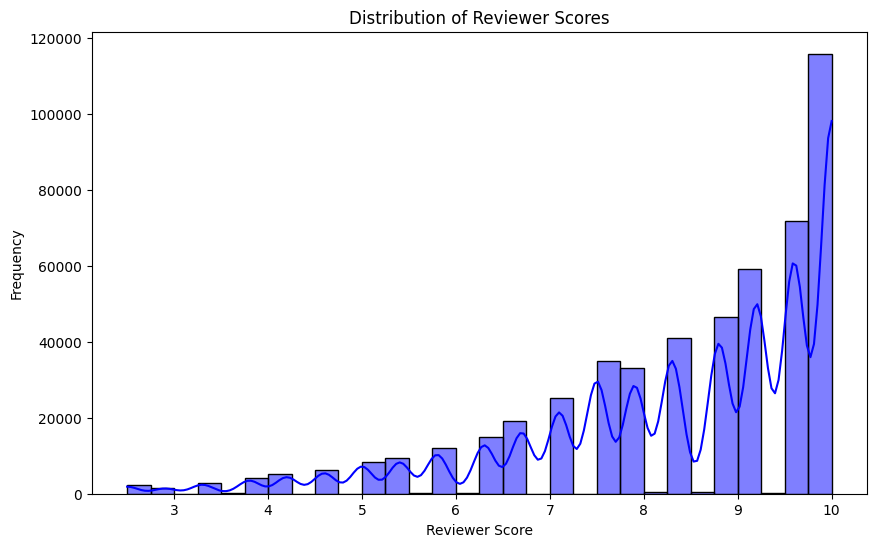

In [13]:
# 3. Distribution of Reviewer Scores
plt.figure(figsize=(10, 6))
sns.histplot(reviews_data['Reviewer_Score'], bins=30, kde=True, color='blue')
plt.title("Distribution of Reviewer Scores")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.show()

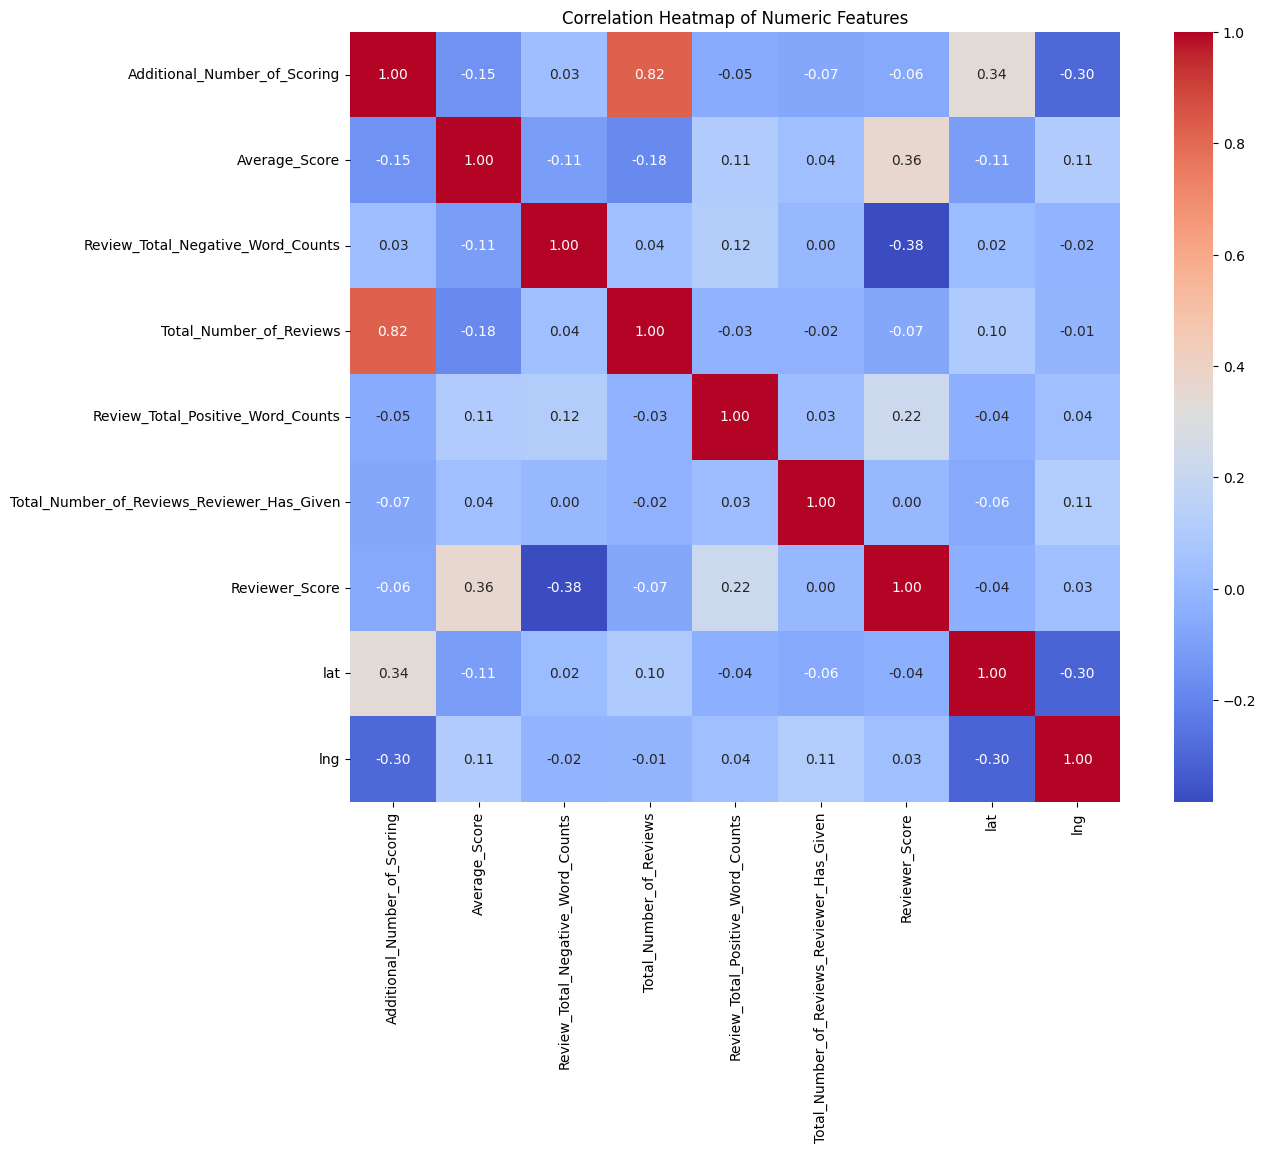

In [15]:
# Select only numeric columns for correlation analysis
numeric_cols = reviews_data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap of the correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

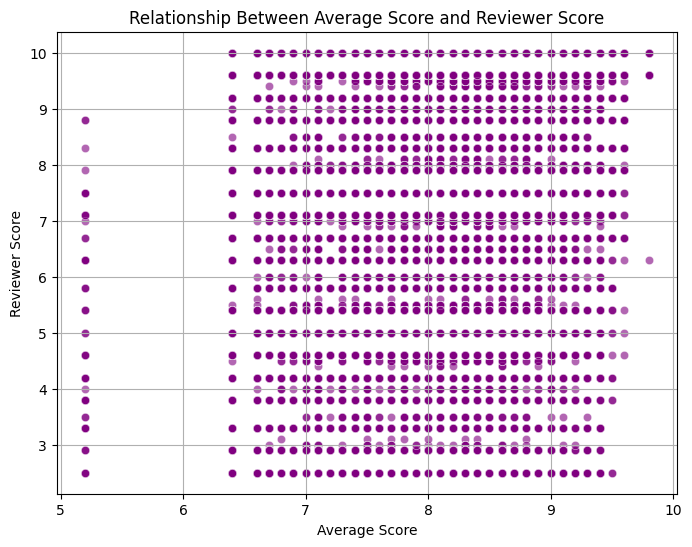

In [16]:
# 5. Average Score vs. Reviewer Score
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reviews_data, x='Average_Score', y='Reviewer_Score', color='purple', alpha=0.6)
plt.title("Relationship Between Average Score and Reviewer Score")
plt.xlabel("Average Score")
plt.ylabel("Reviewer Score")
plt.grid(True)
plt.show()

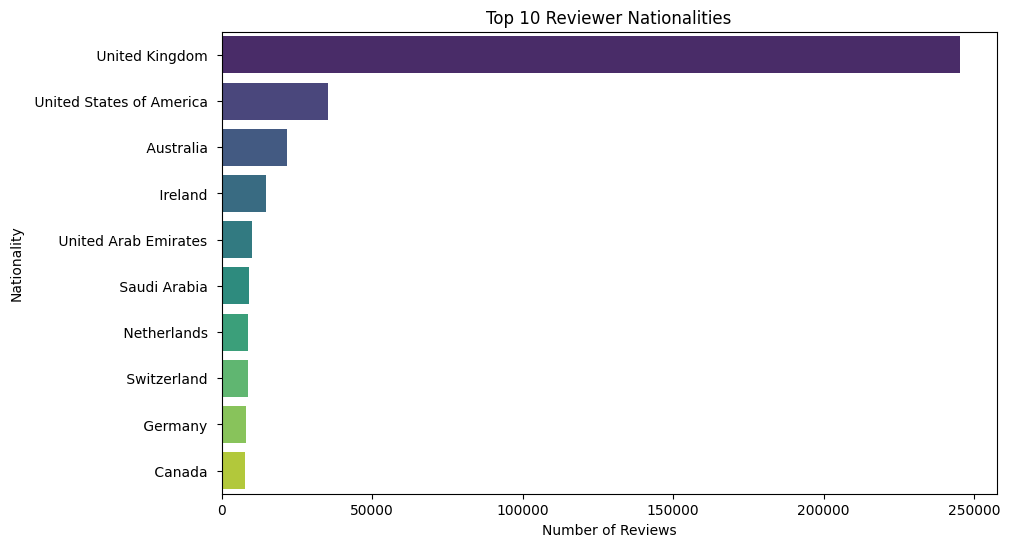

In [52]:
# 6. Top 10 Reviewer Nationalities
top_nationalities = reviews_data['Reviewer_Nationality'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette="viridis")
plt.title("Top 10 Reviewer Nationalities")
plt.xlabel("Number of Reviews")
plt.ylabel("Nationality")
plt.show()

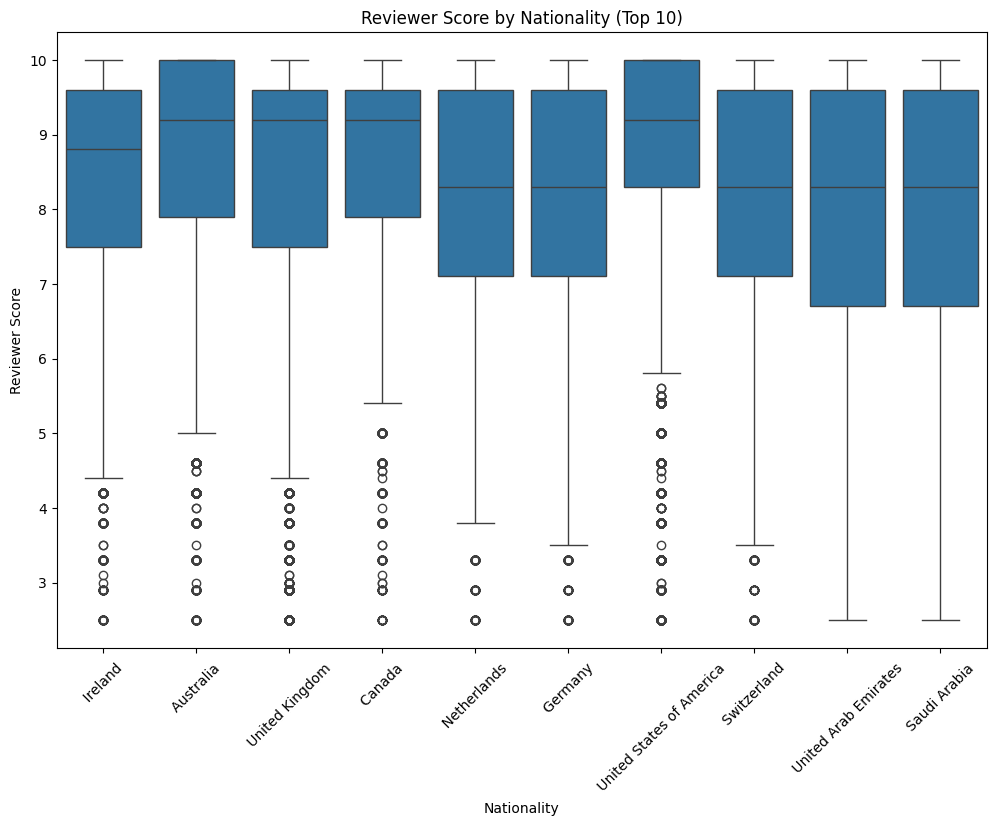

In [18]:
# 7. Nationality vs. Reviewer Score (Top 10 Nationalities)
plt.figure(figsize=(12, 8))
sns.boxplot(data=reviews_data[reviews_data['Reviewer_Nationality'].isin(top_nationalities.index)], 
            x='Reviewer_Nationality', y='Reviewer_Score')
plt.title("Reviewer Score by Nationality (Top 10)")
plt.xlabel("Nationality")
plt.ylabel("Reviewer Score")
plt.xticks(rotation=45)
plt.show()

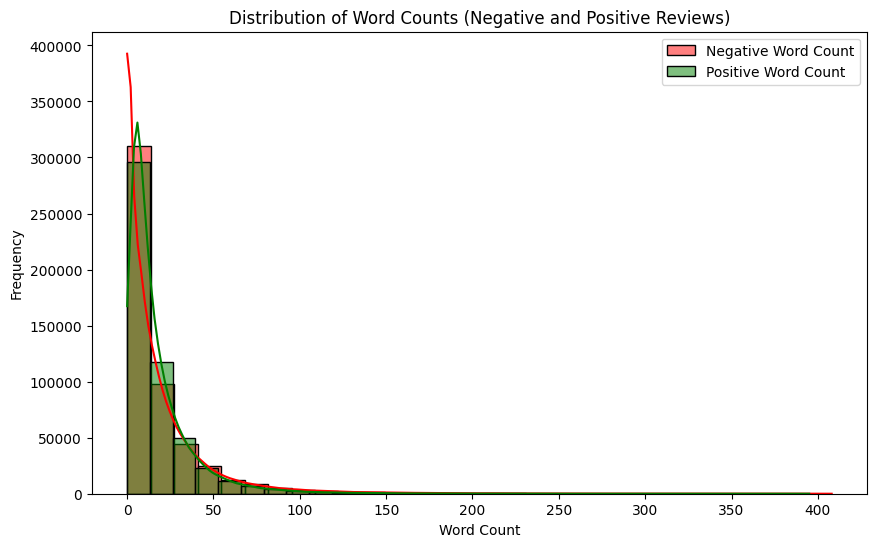

In [19]:
# 8. Negative and Positive Word Counts
plt.figure(figsize=(10, 6))
sns.histplot(reviews_data['Review_Total_Negative_Word_Counts'], bins=30, kde=True, color='red', label='Negative Word Count')
sns.histplot(reviews_data['Review_Total_Positive_Word_Counts'], bins=30, kde=True, color='green', label='Positive Word Count')
plt.title("Distribution of Word Counts (Negative and Positive Reviews)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

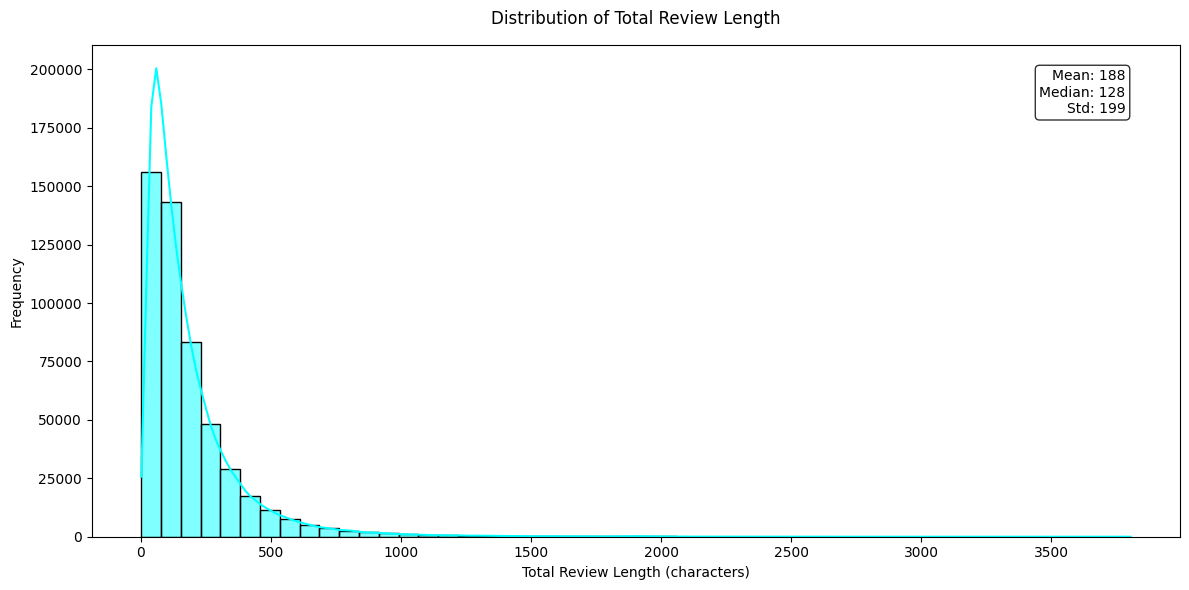

In [60]:
# 9. Length of Reviews Analysis

def analyze_review_length_distribution(reviews_data):
    """
    Analyze and visualize the distribution of total review lengths.
    
    Parameters:
    reviews_data (pd.DataFrame): DataFrame containing review data
    
    Returns:
    pd.DataFrame: DataFrame with added length columns
    """
    # Check required columns
    required_columns = ['Negative_Review', 'Positive_Review']
    if not all(col in reviews_data.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in reviews_data.columns]
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Calculate lengths
    reviews_data['Negative_Review_Length'] = reviews_data['Negative_Review'].str.len()
    reviews_data['Positive_Review_Length'] = reviews_data['Positive_Review'].str.len()
    reviews_data['Total_Review_Length'] = reviews_data['Negative_Review_Length'] + reviews_data['Positive_Review_Length']

    # Create distribution plot
    plt.figure(figsize=(12, 6))
    sns.histplot(data=reviews_data, x='Total_Review_Length', 
                bins=50, kde=True, color='cyan')
    plt.title('Distribution of Total Review Length', fontsize=12, pad=15)
    plt.xlabel('Total Review Length (characters)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    
    # Add summary statistics annotation
    stats = reviews_data['Total_Review_Length'].describe()
    stats_text = f'Mean: {stats["mean"]:.0f}\nMedian: {stats["50%"]:.0f}\nStd: {stats["std"]:.0f}'
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    return reviews_data

# Execute the analysis
try:
    reviews_data = analyze_review_length_distribution(reviews_data)
except Exception as e:
    print(f"An error occurred during analysis: {str(e)}")

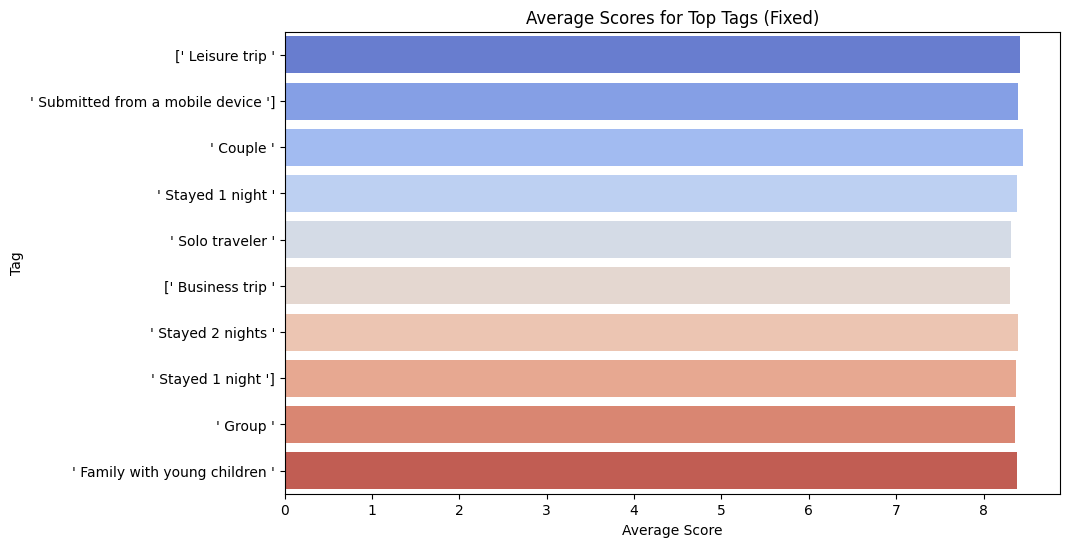

In [54]:
# 10. Average Score by Tags

# Step 1: Preprocess Tags to Extract Unique Tags
# Flatten all tags into a single list
from collections import Counter

all_tags = [tag.strip() for tag_list in reviews_data['Tags'].dropna() for tag in tag_list.split(',')]
tag_counts = Counter(all_tags)

# Select the top 10 most common tags
top_tags = [tag for tag, _ in tag_counts.most_common(10)]

# Ensure the Tags column is a string
reviews_data['Tags'] = reviews_data['Tags'].astype(str)

# Step 2: Create Dummy Variables for Only the Top Tags
for tag in top_tags:
    # Use regex=False to avoid interpreting special characters in tags as regex
    reviews_data[f'Tag_{tag}'] = reviews_data['Tags'].str.contains(tag, regex=False).fillna(False).astype(int)

# Step 3: Calculate Average Scores for Each Tag
average_scores_by_tag = {
    tag: reviews_data.loc[reviews_data[f'Tag_{tag}'] == 1, 'Average_Score'].mean()
    for tag in top_tags
}

# Step 4: Plot the Results
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(average_scores_by_tag.values()), 
    y=list(average_scores_by_tag.keys()), 
    palette='coolwarm'
)
plt.title("Average Scores for Top Tags (Fixed)")
plt.xlabel("Average Score")
plt.ylabel("Tag")
plt.show()

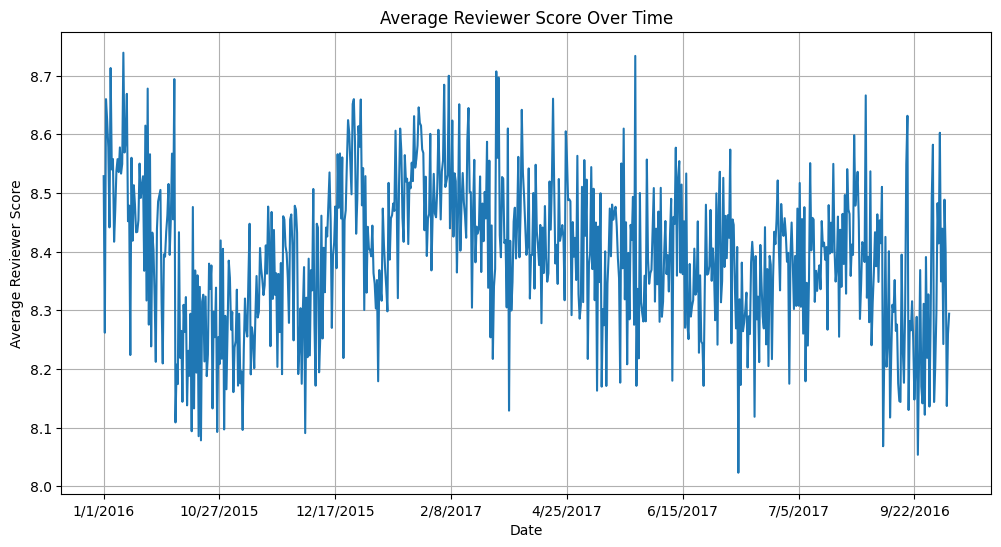

In [24]:
# 11. Reviewer Score Over Time
plt.figure(figsize=(12, 6))
reviews_data.groupby('Review_Date')['Reviewer_Score'].mean().plot()
plt.title("Average Reviewer Score Over Time")
plt.xlabel("Date")
plt.ylabel("Average Reviewer Score")
plt.grid()
plt.show()

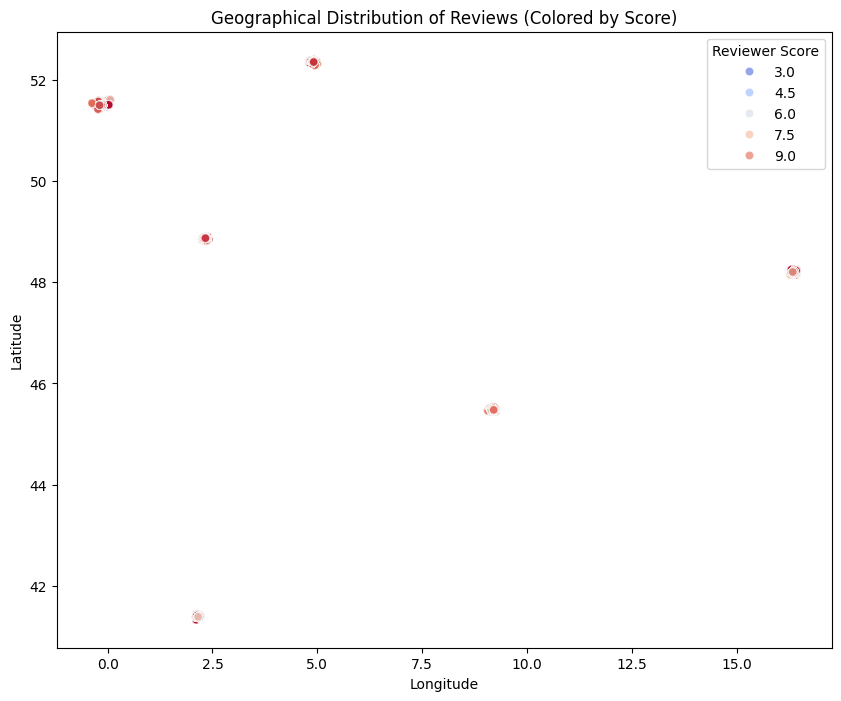

In [25]:
# 12. Latitude and Longitude Analysis (Geospatial Analysis)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reviews_data['lng'], y=reviews_data['lat'], hue=reviews_data['Reviewer_Score'], palette='coolwarm', alpha=0.6)
plt.title("Geographical Distribution of Reviews (Colored by Score)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Reviewer Score")
plt.show()

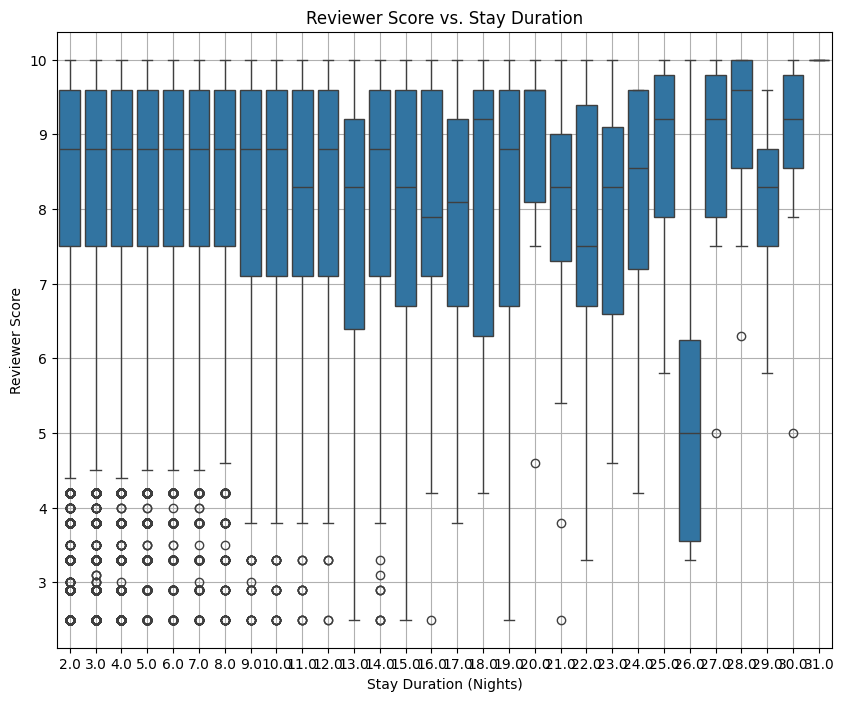

In [26]:
# 13. Reviewer Score vs. Stay Duration
# Extract stay duration from tags
reviews_data['Stay_Duration'] = reviews_data['Tags'].str.extract(r'Stayed (\d+) nights').astype(float)
plt.figure(figsize=(10, 8))
sns.boxplot(x=reviews_data['Stay_Duration'], y=reviews_data['Reviewer_Score'])
plt.title("Reviewer Score vs. Stay Duration")
plt.xlabel("Stay Duration (Nights)")
plt.ylabel("Reviewer Score")
plt.grid()
plt.show()

## Data Analysis

## Classifying `High_Score` through Random Forest Classifier

In [46]:
# Encode categorical variables (Reviewer_Nationality and Tags)
label_encoder = LabelEncoder()
reviews_data['Encoded_Nationality'] = label_encoder.fit_transform(reviews_data['Reviewer_Nationality'])

# Define target variable (Classifying high/low scores based on average)
reviews_data['High_Score'] = (reviews_data['Reviewer_Score'] > reviews_data['Reviewer_Score'].mean()).astype(int)

# Select features and target
features = ['Encoded_Nationality', 'Total_Review_Length', 'Average_Score', 'Review_Total_Negative_Word_Counts',
            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews']

X = reviews_data[features]
y = reviews_data['High_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.7381820297048901

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69     44450
           1       0.76      0.78      0.77     58698

    accuracy                           0.74    103148
   macro avg       0.73      0.73      0.73    103148
weighted avg       0.74      0.74      0.74    103148



In [58]:
# Create binary columns for each tag
for tag in top_tags:
    clean_tag = tag.strip('[] ')  # Remove brackets and spaces
    col_name = f'Tag_{clean_tag}'
    reviews_data[col_name] = reviews_data['Tags'].apply(lambda x: 1 if clean_tag in str(x) else 0)

# Create feature lists
tag_features = [f'Tag_{tag.strip("[] ")}' for tag in top_tags]
basic_features = [
    'Total_Review_Length', 
    'Review_Total_Negative_Word_Counts', 
    'Review_Total_Positive_Word_Counts'
]

# Combine features
all_features = tag_features + basic_features

## Predicting `Reviewer_Score` through Random Forest Regressor

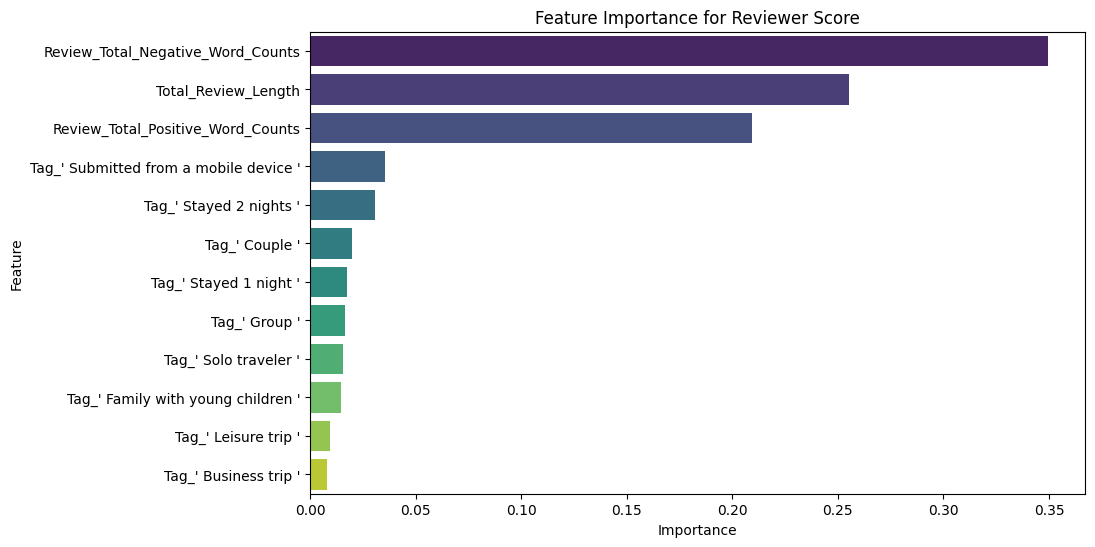

In [62]:
# Create X and y
X = reviews_data[all_features]
y = reviews_data['Reviewer_Score']

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='viridis')
plt.title("Feature Importance for Reviewer Score")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Use the best model for predictions
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

# Evaluate tuned model
print("\nTuned Model Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  54.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  24.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  27.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  28.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total ti

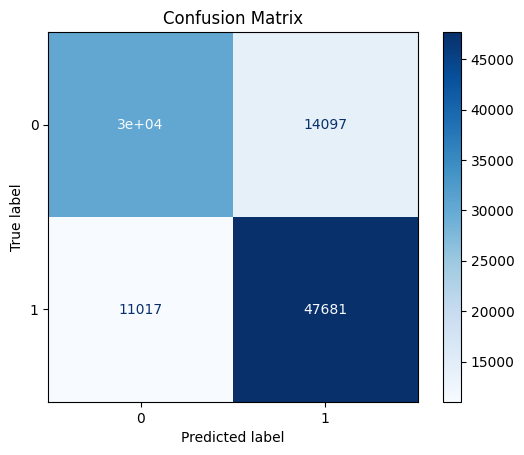

In [58]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tuned)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Refining the Random Forest Model by creating new features

In [64]:
# Ensure text columns exist and handle missing or non-string data
reviews_data['Positive_Review'] = reviews_data['Positive_Review'].fillna("").astype(str)
reviews_data['Negative_Review'] = reviews_data['Negative_Review'].fillna("").astype(str)

# Add sentiment scores as new features
reviews_data['Positive_Sentiment'] = reviews_data['Positive_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_data['Negative_Sentiment'] = reviews_data['Negative_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Add derived features for sentiment polarity
reviews_data['Sentiment_Polarity_Difference'] = reviews_data['Positive_Sentiment'] - reviews_data['Negative_Sentiment']
reviews_data['Sentiment_Polarity_Ratio'] = reviews_data['Review_Total_Positive_Word_Counts'] / (
    reviews_data['Review_Total_Negative_Word_Counts'] + 1e-5  # To avoid division by zero
)

# Verify the new features
print("New Sentiment Features:\n", reviews_data[['Sentiment_Polarity_Difference', 'Sentiment_Polarity_Ratio']].head())

# Update features list to include new sentiment features
if 'features' not in locals():
    # Define the base features if not defined
    features = ['Total_Review_Length', 'Average_Score', 'Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts', 'Encoded_Nationality']

features.extend(['Positive_Sentiment', 'Negative_Sentiment', 'Sentiment_Polarity_Difference', 'Sentiment_Polarity_Ratio'])

# Re-train the Random Forest model with new features
X = reviews_data[features]
y = reviews_data['High_Score']  # Ensure this is already defined as a binary target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the previously trained best_rf model (ensure it's defined)
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_sentiment = best_rf.predict(X_test)

# Evaluate the model with sentiment analysis features
print("Accuracy Score (with Sentiment Features):", accuracy_score(y_test, y_pred_sentiment))
print("\nClassification Report (with Sentiment Features):\n", classification_report(y_test, y_pred_sentiment))

New Sentiment Features:
    Sentiment_Polarity_Difference  Sentiment_Polarity_Ratio
0                       0.254662              2.770781e-02
1                       0.091960              1.050000e+07
2                       0.427347              4.999999e-01
3                       0.695370              1.238095e-01
4                       0.309091              5.714285e-02
Accuracy Score (with Sentiment Features): 0.7648233606080583

Classification Report (with Sentiment Features):
               precision    recall  f1-score   support

           0       0.74      0.70      0.72     44450
           1       0.78      0.82      0.80     58698

    accuracy                           0.76    103148
   macro avg       0.76      0.76      0.76    103148
weighted avg       0.76      0.76      0.76    103148



## Clustering

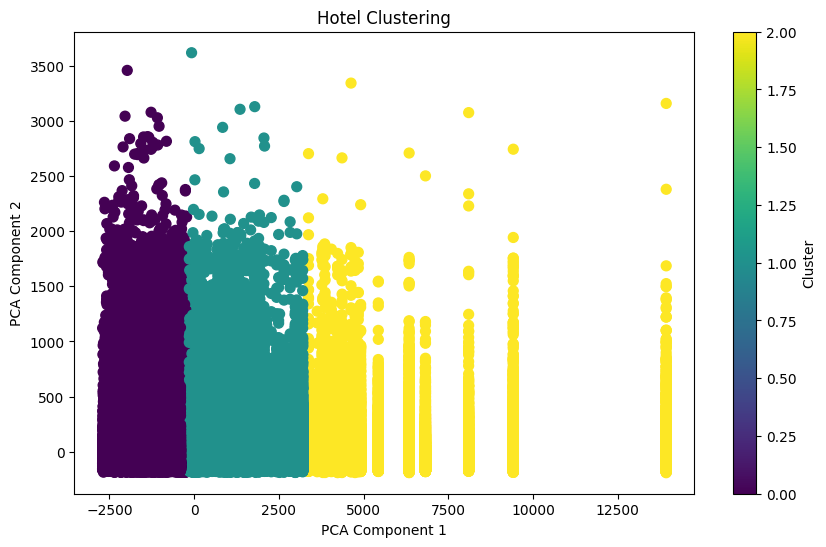

In [65]:
# Features for clustering
clustering_features = ['Average_Score', 'Total_Review_Length', 'Total_Number_of_Reviews']

# PCA for dimensionality reduction (2 components)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(reviews_data[clustering_features].dropna())

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=reviews_data['Cluster'], cmap='viridis', s=50)
plt.title("Hotel Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [66]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
reviews_data['Cluster'] = kmeans.fit_predict(pca_data)

# Perform clustering using latitude and longitude
location_features = ['lat', 'lng']
geo_kmeans = KMeans(n_clusters=4, random_state=42)
reviews_data['Geo_Cluster'] = geo_kmeans.fit_predict(reviews_data[location_features].dropna())

# Plot on a map
map_clusters = folium.Map(location=[reviews_data['lat'].mean(), reviews_data['lng'].mean()], zoom_start=5)
colors = ['red', 'blue', 'green', 'purple']

# Add points to the map
for _, row in reviews_data.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lng']),
        radius=5,
        color=colors[row['Geo_Cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(map_clusters)

# Display the map
map_clusters.save("clusters_map.html")
print("Clusters map saved as 'clusters_map.html'. Open it in a browser to view.")

Clusters map saved as 'clusters_map.html'. Open it in a browser to view.


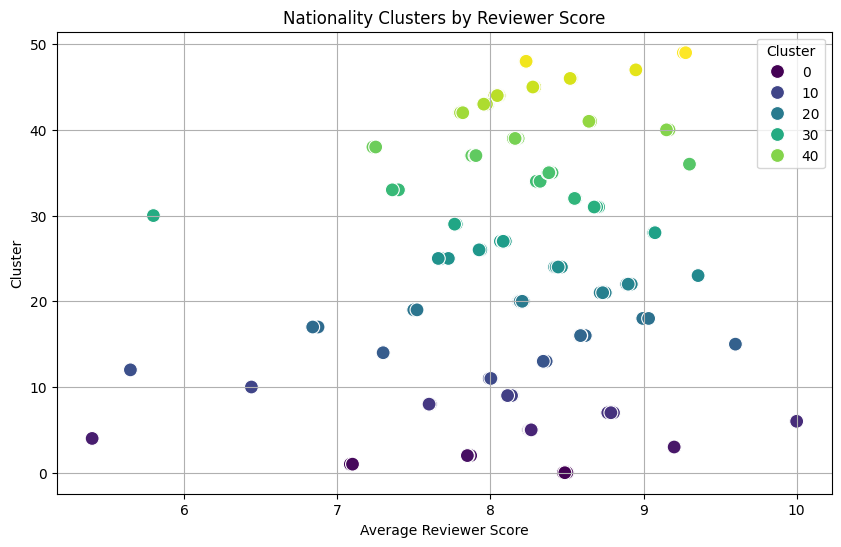

Cluster
0     [ Barbados ,  Guatemala ,  Haiti ,  Hungary , ...
1                                   [ Gabon ,  Tuvalu ]
2            [ Mozambique ,  Oman ,  Papua New Guinea ]
3                            [ Burundi ,  South Sudan ]
4                                        [ Montserrat ]
5     [ Albania ,  Indonesia ,  Ivory Coast ,  Latvi...
6     [ Comoros ,  Crimea ,  Equatorial Guinea ,  Sv...
7     [ Antarctica ,  Honduras ,  Panama ,  Puerto R...
8                 [ Bangladesh ,  Libya ,  Seychelles ]
9     [ Armenia ,  Cambodia ,  Cameroon ,  France , ...
10                                             [ Mali ]
11                   [ ,  Kuwait ,  Lebanon ,  Turkey ]
12                                   [ American Samoa ]
13    [ Abkhazia Georgia ,  Bosnia and Herzegovina ,...
14                [ Cook Islands ,  Wallis and Futuna ]
15                                       [ Cape Verde ]
16    [ Australia ,  Bahamas ,  Bermuda ,  Cura ao ,...
17                             [ Afghani

In [70]:
# Group by Reviewer_Nationality and calculate average score
nationality_data = reviews_data.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().reset_index()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=50, random_state=42)
nationality_data['Cluster'] = kmeans.fit_predict(nationality_data[['Reviewer_Score']])

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=nationality_data, x='Reviewer_Score', y='Cluster', hue='Cluster', palette='viridis', s=100)
plt.title("Nationality Clusters by Reviewer Score")
plt.xlabel("Average Reviewer Score")
plt.ylabel("Cluster")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Check nationality distribution within clusters
print(nationality_data.groupby('Cluster')['Reviewer_Nationality'].apply(list))

## Outlier Detection

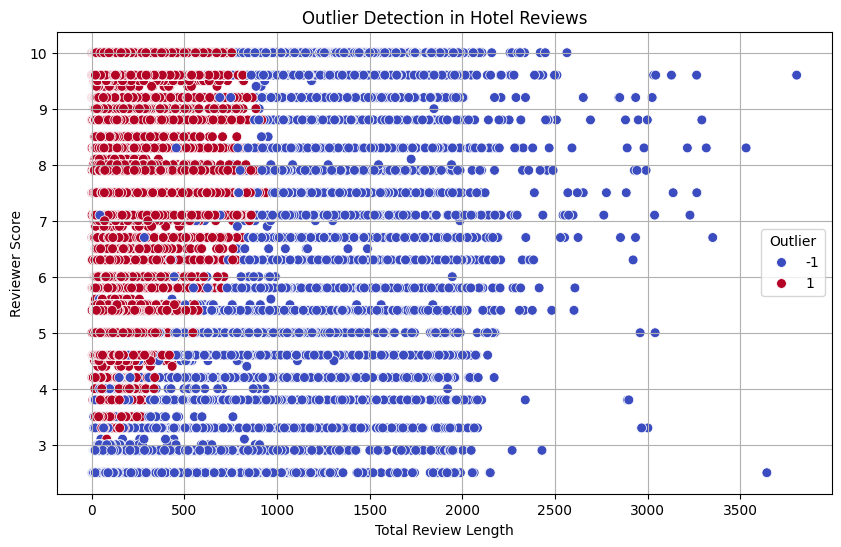

In [71]:
# Select features for outlier detection
outlier_features = ['Reviewer_Score', 'Total_Review_Length', 'Sentiment_Polarity_Difference']
iso_forest = IsolationForest(contamination=0.05, random_state=42)
reviews_data['Outlier'] = iso_forest.fit_predict(reviews_data[outlier_features])

# Visualize outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews_data, x='Total_Review_Length', y='Reviewer_Score', hue='Outlier', palette='coolwarm', s=50)
plt.title("Outlier Detection in Hotel Reviews")
plt.xlabel("Total Review Length")
plt.ylabel("Reviewer Score")
plt.legend(title="Outlier")
plt.grid()
plt.show()

In [73]:
# Perform clustering using latitude and longitude
geo_features = ['lat', 'lng']
geo_kmeans = KMeans(n_clusters=4, random_state=42)
reviews_data['Geo_Cluster'] = geo_kmeans.fit_predict(reviews_data[geo_features].dropna())

# Visualize the clusters on a map
import folium
map_clusters = folium.Map(location=[reviews_data['lat'].mean(), reviews_data['lng'].mean()], zoom_start=5)

colors = ['red', 'blue', 'green', 'purple']
for _, row in reviews_data.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lng']),
        radius=5,
        color=colors[row['Geo_Cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(map_clusters)

# Save and display the map
map_clusters.save("hotel_geo_clusters.html")
print("Geospatial clusters map saved as 'hotel_geo_clusters.html'. Open it in a browser to view.")

Geospatial clusters map saved as 'hotel_geo_clusters.html'. Open it in a browser to view.
